In [1]:
import numpy as np
import pandas as pd
import torch as torch
import sklearn.preprocessing as preprocessing

In [2]:
replacements = [
["\"This Listing Is For Verified", "This Listing Is For Verified", -1],
["\"This subtropical", "This subtropical", -1],
["\"This po", "This po", -1],
["\"Mr. H", "Mr. H", -1],
["\"An engaging", "An engaging", -1],
[",\"Professional F", ",Professional F", -1],
[",\"Professional D", ",Professional D", -1],
["SKU:90183\"", "SKU:90183", -1],
["\"Encryption", "Encryption", -1],
["\"ProSoma", "ProSoma", -1],
["\"If you’", "If you’", -1],
[",\"Named", "Named", -1],
[",\"THC", ",THC", -1],
["\"Strassman'", "Strassman'", -1],
["\"You d", "You d", -1],
[",\"This is your", ",This is your", -1],
["35,\"P", "35,P", -1],
["wing,\"", "wing,", -1],
["22,\"I", "22,I", -1],
[",\"G13", ",G13", -1],
["0,\"Pl", "0,Pl", -1],
["s Sunglasses Replica are 1:1  ...", "s Sunglasses Replica are 1:1 ...\"", -1],
["],,,,", "],", -1],
[",David Icke (", ",\"David Icke (", -1],
["r Bud,I", "r Bud,\"I", -1],
["hone,B", "hone,\"B", -1],
["h,I r", "h,\"I r", -1],
[".,0.01547", ".\",0.01547", -1],
["~5/5,,", "~5/5,", -1],
[".,2.32555", ".\",2.32555", -1],
["/5,,", "/5,", -1],
[".,0.130088", ".\",0.130088", -1],
["tazepam,", "tazepam\",", -1],
["E,15.8", "E\",15.8", -1],
["Quality\"\" we've all come to know and love. This MD ...\",1", 
                        "Quality we've all come to know and love. This MD ...,1", -1] ]

with open("Agora2.csv", "wb") as nuevoArchivo: # trunca el archivo si ya existe
    with open("Agora.csv", mode="r", encoding="UTF-8", errors="ignore") as archivoOriginal:
        numero = 1
        for linea in archivoOriginal:
            if numero == 13000:
                break
            try:
                # se corrigen los errores encontrados
                for rep in replacements:
                    modified = False
                    if rep[0] in linea:
                        if not modified:
                            rep[2] = numero
                            modified = True
                        linea = linea.replace(rep[0], rep[1])
                
                # se almacena el texto en el nuevo archivo
                linea = linea.encode("utf-8")
                nuevoArchivo.write(linea)
            except Exception as e:
                print("Error con el string", numero, linea, e)
                raise e
            finally:
                numero += 1

# replacements

In [3]:
df = pd.read_csv("Agora2.csv")
df.describe()

,Vendor,Category,Item,Item Description,Price,Origin,Destination,Rating,Remarks
count,12998,12998,12998,12997,12997,10897,6325,12996,2261
unique,943,37,12886,9134,12749,110,216,181,1
top,fake,Drugs/Cannabis/Weed,Social Engineering: The Art of Human Hacking,This shipment is with tracking number. The shi...,0.00415549 BTC,USA,Worldwide,5.00/5,Average price may be skewed outliar > .5 BTC f...
freq,478,2414,3,96,29,3140,1840,1785,2261


In [4]:
print('Cantidad de filas iniciales:', df.shape[0])

# queda en 10737 si outliers
df = df[df[" Remarks"] != "Average price may be skewed outliar > .5 BTC found"]
print('Cantidad de filas sin outliars:', df.shape[0])

# Elimina entradas sin rating
df.dropna(subset = [" Rating"], inplace=True)
print('Cantidad de filas con rating no nulo:', df.shape[0])

# se deja los Ratings válidos - que terminan en '/5'
df = df[df[" Rating"].str.endswith("/5")]
print('Cantidad de filas con ratings válidos:', df.shape[0])

# Todas las entradas tienen precio, entonces **no elimina** ninguna fila
df.dropna(subset = [" Price"], inplace=True)
print('Cantidad de filas con precio:', df.shape[0])

# Verifica la cantidad de entradas que terminan con 'BTC'
print('cantidad de precios en BTC:', df[" Price"].str.endswith('BTC').count() )

# texto a números
df[" Price"]  = df[" Price"].str.replace(" BTC" , "")
df[" Rating"] = df[" Rating"].str.replace("/5" , "")
df[" Rating"] = df[" Rating"].str.replace("~" , "")
df[" Price"]  = pd.to_numeric(df[" Price"], errors ="coerce")
df[" Rating"] = pd.to_numeric(df[" Rating"], errors ="coerce")



# eliminar features no necesarios
df.drop(columns=[" Item", " Item Description", " Origin", " Destination", " Remarks"], inplace=True)
print('Columnas restantes:', df.columns)

df.describe()

Cantidad de filas iniciales: 12998
Cantidad de filas sin outliars: 10737
Cantidad de filas con rating no nulo: 10735
Cantidad de filas con ratings válidos: 10138
Cantidad de filas con precio: 10138
cantidad de precios en BTC: 10138
Columnas restantes: Index(['Vendor', ' Category', ' Price', ' Rating'], dtype='object')


,Price,Rating
count,1.013800e+04,10138.000000
mean,3.215423e+00,4.890305
std,2.233866e+02,0.254192
min,1.000000e-07,0.000000
25%,7.196610e-02,4.880000
50%,2.103860e-01,4.960000
75%,5.163252e-01,4.996000
max,2.198500e+04,5.000000


In [5]:
def soloCategoria(cat):
    posInicio = cat.find("/")
    if posInicio == -1:
        return cat
    
    posFin = cat.rindex("/")
    if posInicio == posFin:
        return cat[posInicio+1:]
    return cat[posInicio+1:posFin]

# usa la subcategoría
df[" Category"] = df[ " Category" ].apply(soloCategoria)

# codifica la categoría usando one-hot-encoding
oneHotEncoded = pd.get_dummies(df, columns=[" Category"], prefix="Cat")


## Retorna la categoría correspondiente al rating.
## El valor Rating de los datos está en el rango [2.6, 5.0]
## Categorías resultantes:
## - 2: bueno
## - 1: regular
## - 0: malo
def categoriasDeRating(valor):
    if valor > 4.1:
        return 2 # bueno
    if valor > 3.2:
        return 1 # regular
    return 0 #malo

# df[" Rating"] = df[ " Rating" ].apply(categoriasDeRating)

In [6]:
print(df[" Rating"])
print(oneHotEncoded.shape)
print(oneHotEncoded.columns)
df.describe()

0        4.96
1        4.96
2        4.93
3        4.89
4        4.88
         ... 
12988    5.00
12989    5.00
12991    5.00
12993    5.00
12997    5.00
Name:  Rating, Length: 10138, dtype: float64
(10138, 29)
Index(['Vendor', ' Price', ' Rating', 'Cat_Accessories', 'Cat_Accounts',
       'Cat_Benzos', 'Cat_Cannabis', 'Cat_Cannabis/Shake', 'Cat_Clothing',
       'Cat_Dissociatives', 'Cat_Ecstasy', 'Cat_Electronics', 'Cat_Guides',
       'Cat_Hacking', 'Cat_Jewelry', 'Cat_Money', 'Cat_Other',
       'Cat_Physical documents', 'Cat_Pipes', 'Cat_Pirated',
       'Cat_Prescription', 'Cat_RCs', 'Cat_Scans', 'Cat_Smoked',
       'Cat_Software', 'Cat_Steroids', 'Cat_Watches', 'Cat_Weight loss',
       'Cat_eBooks'],
      dtype='object')


,Price,Rating
count,1.013800e+04,10138.000000
mean,3.215423e+00,4.890305
std,2.233866e+02,0.254192
min,1.000000e-07,0.000000
25%,7.196610e-02,4.880000
50%,2.103860e-01,4.960000
75%,5.163252e-01,4.996000
max,2.198500e+04,5.000000


In [14]:
# regresión lineal

# modelo lineal
def modeloLineal(x, w, b):
    return x @ w + b

# función de cálculo de error, usando mse
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()


def regresionLineal(modelo, metrica, iteraciones, inputs, targets):
    errores = []
    torch.manual_seed(0)
    w = torch.randn(inputs.shape[1], 1, dtype=torch.float64, requires_grad=True)
    b = torch.randn(1, dtype=torch.float64, requires_grad=True)
    
    for epoch in range(iteraciones):
        preds = modelo(inputs, w, b)
        loss = metrica(preds, targets)
        loss.backward()
        with torch.no_grad():
            w -= w.grad * 1e-5
            b -= b.grad * 1e-5
            w.grad.zero_()
            b.grad.zero_()
            errores.append(loss.numpy())
            
    return errores

def testRegresionLineal():
    target = torch.tensor(oneHotEncoded[" Rating"].values)
    inputdf = oneHotEncoded.drop(columns=["Vendor", " Rating"])
    inputs = torch.tensor(inputdf.values)
    print(inputs.shape)
    
    iteraciones = 5
    
    errores = regresionLineal(modeloLineal, mse, iteraciones, inputs, target)
    print(errores)
    
testRegresionLineal()

torch.Size([10138, 27])
[array(266514.95514269), array(35.34731673), array(34.42339438), array(34.4218407), array(34.42029029)]


In [8]:
df=df[df[" Price"] <= 5]

df.fillna(df[" Price"].median(), inplace = True)
df.fillna(df[" Rating"].median(), inplace = True)
df = df.round({" Rating": 2, " Price": 4})

In [9]:
val = {}
ind_val = 1
for cate in df[" Category"].unique():
    if cate not in val:
        val.update({cate: ind_val})
        ind_val += 1

def cateToNum(cat):
    if cat in val:
        return val[cat]

# usa la subcategoría
df[" Category"] = df[ " Category" ].apply(cateToNum)

# codifica la categoría
print(val)

{'Hacking': 1, 'Other': 2, 'RCs': 3, 'Physical documents': 4, 'Smoked': 5, 'Money': 6, 'Software': 7, 'Accounts': 8, 'Clothing': 9, 'eBooks': 10, 'Electronics': 11, 'Pipes': 12, 'Weight loss': 13, 'Pirated': 14, 'Steroids': 15, 'Prescription': 16, 'Guides': 17, 'Scans': 18, 'Jewelry': 19, 'Accessories': 20, 'Watches': 21, 'Cannabis': 22, 'Benzos': 23, 'Cannabis/Shake': 24, 'Dissociatives': 25, 'Ecstasy': 26}


In [10]:
val3 = {}
ind_val3 = 1
for cate in df["Vendor"].unique():
    if cate not in val:
        val3.update({cate: ind_val3})
        ind_val3 += 1

def vendorToNum(cat):
    if cat in val3:
        return val3[cat]

# usa la subcategoría
df["Vendor"] = df[ "Vendor" ].apply(vendorToNum)

In [11]:
# val2 = {}
# ind_val2 = 1
# for cate in df[" Item"].unique():
#     if cate not in val:
#         val2.update({cate: ind_val2})
#         ind_val2 += 1

# def itemToNum(cat):
#     if cat in val2:
#         return val2[cat]

# # usa la subcategoría
# df[" Item"] = df[ " Item" ].apply(itemToNum)

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

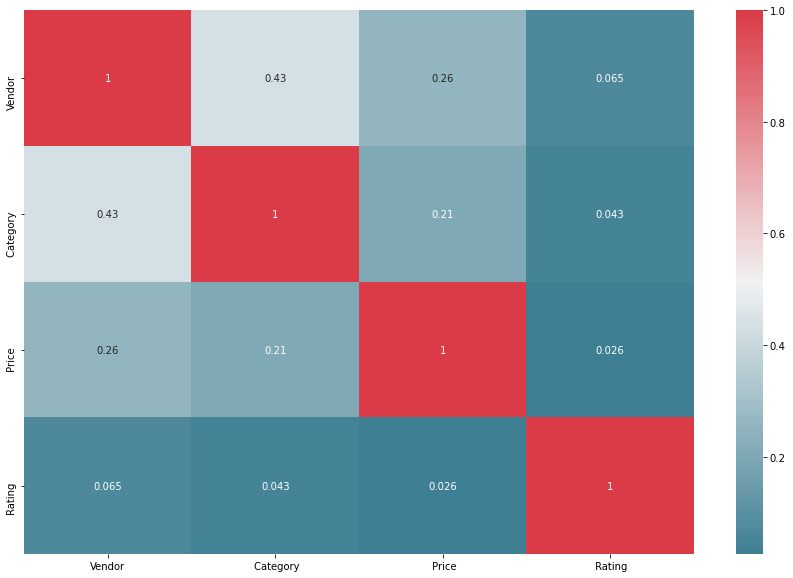

In [13]:
_,ax=plt.subplots(figsize=(15,10))
colormap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(df.corr(),annot=True,cmap=colormap)